# 01 – Autencoder adventures

## Task

* Look here https://www.doc.ic.ac.uk/~js4416/163/website/nlp/
* take N classes of wikipedia articles, for each class – 1000 articles
* create an autoencoder to compress the articles
* perform classification with typical classifier.
* Discussion: Compare to PCA

## Preliminary discussion

This work was quiet novel to me, it was my first contact with autoencoders. I found it to be a deep and very interesting subject and would love to get the opportunity to go deeper. Given the limited time I had to work on the task, I focused on the main concepts and the project structure. There is a lot of improvement to be done, especially in the hyper-parameters tuning and finding the correct encoder architecture.

## References

https://blog.keras.io/building-autoencoders-in-keras.html  
https://jovianlin.io/embeddings-in-keras/  

## Imports

In [1]:
import helpers # some general functions for loading, writting and plotting stuff
import re
import pandas as pd
import numpy as np

In [2]:
from keras.layers import Input, Dense, Embedding, Flatten
from keras import regularizers
from keras.models import Model, Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot, Tokenizer

C:\Users\Thibault\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

## Some constants

I decided to go with 32 as the dimension of the latent space since it gave the best classification results afterwards. I believe in concrete work this would greatly depend on the task.

In [4]:
LATENT_SPACE_DIM = 32
MAX_WORDS = 1_000

## Data preparation

### Load data

In [5]:
full_data = helpers.most_recent_dataset()

In [6]:
# change this to vary subset size for testing
data = full_data.sample(int(len(full_data) * 1))

### Labels

In [7]:
le = preprocessing.LabelEncoder()
le.fit(data['label'])
y = le.transform(data['label'])

### Embedding

Here we use a simple word2vec style approach. GloVe pretrained vectors could ameliorate the results.

In [8]:
docs = data['content']

In [9]:
%%time
tk = Tokenizer()
tk.fit_on_texts(docs)

Wall time: 15.1 s


In [10]:
%%time
tk.num_words = MAX_WORDS
docs_seq = tk.texts_to_sequences(docs)

Wall time: 11.8 s


In [11]:
pad_len = int(pd.DataFrame([len(e) for e in docs_seq]).mean())
X_padded = pad_sequences(docs_seq, maxlen=pad_len, padding='post')

In [12]:
model = Sequential()
model.add(Embedding(input_dim=MAX_WORDS, output_dim=50, input_length=pad_len))
model.add(Flatten())
model.compile('rmsprop', 'mse')

X = model.predict(X_padded)

In [13]:
X.shape

(8000, 53300)

## Autoencoder

The actual autoencoder. I chosed to keep it shallow, without hidden layers, to iterate faster. Improvement on the architecture (ammount, type and size of the layers) would be at the core of further reaserch on this task.

In [14]:
input_dim = X.shape[1]
target_dim = LATENT_SPACE_DIM
activation_type = 'tanh' # tried 'relu', but 'tanh' performs better


### Architecture
input_text = Input(shape=(input_dim,))
encoded = Dense(128, activation=activation_type)(input_text)
encoded_out = Dense(target_dim, activation=activation_type, 
                activity_regularizer=regularizers.l1(10e-5))(encoded) # constrain so that less neurons fire at the same time -> latent representations are sparser
# "latent space"
decoded = Dense(128, activation=activation_type)(encoded_out)
decoded_out = Dense(input_dim, activation='sigmoid')(decoded)

### Autoencoder
autoencoder = Model(input_text, decoded_out)

### Encoder
encoder = Model(input_text, encoded_out)

In [15]:
# 'mse' performed better than 'binary_cross_entropy'
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 53300)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               6822528   
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_4 (Dense)              (None, 53300)             6875700   
Total params: 13,706,580
Trainable params: 13,706,580
Non-trainable params: 0
_________________________________________________________________


In [16]:
%%time
# The autoencoder tries to fit the same value as its output than at its input
history = autoencoder.fit(X, X,
                epochs=40,
                batch_size=256,
                validation_split=.2,
                verbose=1)

Train on 6400 samples, validate on 1600 samples
Epoch 1/40
6400/6400 [==============================] - 23s 4ms/step - loss: 0.5314 - acc: 0.0000e+00 - val_loss: 0.3317 - val_acc: 0.0000e+00
Epoch 2/40
6400/6400 [==============================] - 23s 4ms/step - loss: 0.2671 - acc: 0.0000e+00 - val_loss: 0.1885 - val_acc: 0.0000e+00
Epoch 3/40
6400/6400 [==============================] - 23s 4ms/step - loss: 0.1572 - acc: 0.0000e+00 - val_loss: 0.1129 - val_acc: 0.0000e+00
Epoch 4/40
6400/6400 [==============================] - 23s 4ms/step - loss: 0.1135 - acc: 0.0000e+00 - val_loss: 0.0870 - val_acc: 0.0000e+00
Epoch 5/40
6400/6400 [==============================] - 27s 4ms/step - loss: 0.0959 - acc: 0.0000e+00 - val_loss: 0.0720 - val_acc: 0.0000e+00
Epoch 6/40
6400/6400 [==============================] - 24s 4ms/step - loss: 0.0852 - acc: 0.0000e+00 - val_loss: 0.0629 - val_acc: 0.0000e+00
Epoch 7/40
6400/6400 [==============================] - 24s 4ms/step - loss: 0.0737 - acc: 0.0

The graph below shows a pretty standard loss curve over epochs. The accuracy curve on the other hand was more puzzling to me, since both training and validation accuracy are stuck at zero. Wrapping my head around it, I believe its because the reconstruction of the sample is not precise in an autoencoder. We don’t have an easy yes/no answer like we would have with, say, a binary classifier. Thus the loss is the metric that is of actual interest to us.

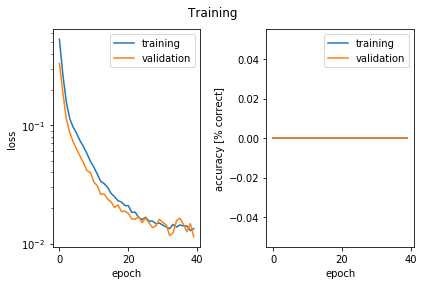

In [17]:
helpers.plot_history(history, 'Training');

## Classification

For the classification part, I’ve decided to use a random forest, the intuition there is that our data might be highly unlinear. Again, for proof of concept purposes we keep the default settings.

In [79]:
def classify_and_evaluate(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
    
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    return clf.predict(X)

### “Raw” classifier

Before trying out our autoencoder, we simply try to classify our raw vectors.

In [68]:
%%time
y_raw = classify_and_evaluate(X, y)

             precision    recall  f1-score   support

  Economics       0.21      0.33      0.26       216
Linguistics       0.26      0.32      0.28       212
 Literature       0.16      0.16      0.16       194
       Math       0.25      0.23      0.24       201
    Oceania       0.26      0.19      0.22       210
   Politics       0.22      0.16      0.18       197
 Prehistory       0.27      0.30      0.28       188
   Religion       0.28      0.19      0.23       182

avg / total       0.24      0.24      0.23      1600

Wall time: 19.7 s


There is nothing much to say. Religion has the higher f1 score, its pages might use more distinctive words, but all in all the result are quite homogenenous.

### PCA

For the comparison to be meaningful, we use the same dimensionality reduction as we did with the autoencoder.

In [69]:
%%time
pca = PCA(n_components=LATENT_SPACE_DIM)
pca.fit(X)
X_pca = pca.transform(X)

Wall time: 22.8 s


In [70]:
%%time
y_pca = classify_and_evaluate(X_pca, y)

             precision    recall  f1-score   support

  Economics       0.17      0.26      0.21       202
Linguistics       0.19      0.25      0.22       194
 Literature       0.19      0.18      0.19       204
       Math       0.43      0.42      0.42       199
    Oceania       0.18      0.16      0.17       198
   Politics       0.16      0.13      0.15       215
 Prehistory       0.30      0.23      0.26       202
   Religion       0.22      0.17      0.19       186

avg / total       0.23      0.23      0.22      1600

Wall time: 919 ms


Unsurprisingly, the PCA performances are very similar to the ones on the raw data on average. Indeed, we performed the same operation, but on the principle axis of our data. After the PCA was done, the classification was very fast.

What we can note though, is that certain classes, like “Math” have a way higher score. I believe that this is because the pages on “math” are more specific and overlap less in term of the vocabulary with the other categories, like “politics” and “economy” could for example.

### Latent space

Now we can classify our pages using there autoencoded versions to see what we get.

In [72]:
%%time
X_latent = encoder.predict(X)

Wall time: 10.1 s


In [80]:
%%time
y_latent = classify_and_evaluate(X_latent, y)

             precision    recall  f1-score   support

  Economics       0.13      0.17      0.15       189
Linguistics       0.16      0.20      0.18       206
 Literature       0.12      0.13      0.13       209
       Math       0.22      0.21      0.22       193
    Oceania       0.14      0.15      0.14       193
   Politics       0.15      0.14      0.14       193
 Prehistory       0.24      0.19      0.21       208
   Religion       0.18      0.13      0.15       209

avg / total       0.17      0.17      0.17      1600

Wall time: 817 ms


We are quite sad to discover that the performances actually went down when using our autoencoder. My intuition is that our dataset was not big enough or maybe classes were not very well formed (quite a lot of heuristics in there construction). More work should be done on the autoencoder part. We denote though that the whole process (once the autoencoder trained…) was faster than PCA.

To go further in the discussion, I think the autoencoder can be assimilated as an approximation of the PCA. On linear data, the result would be quite similar. When data is not linear though, I’d expect it to be able to perform better, even if it failed in the present case.

## Visualisation

To support what is said above, we can project our data on a two dimentional space (again, using PCA).

In [73]:
import warnings
warnings.filterwarnings(action='once') # sklearn processing’s label encoder triggers a lot of warning due to deprecation

### PCA

In the graph below we can see how the data fits pretty well a parabola in two dimension, argument for the non linearity of the data. Math seems to “cluster” well. This is in accordance with the fact noted above that “math” had a good F1 score.

C:\Users\Thibault\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


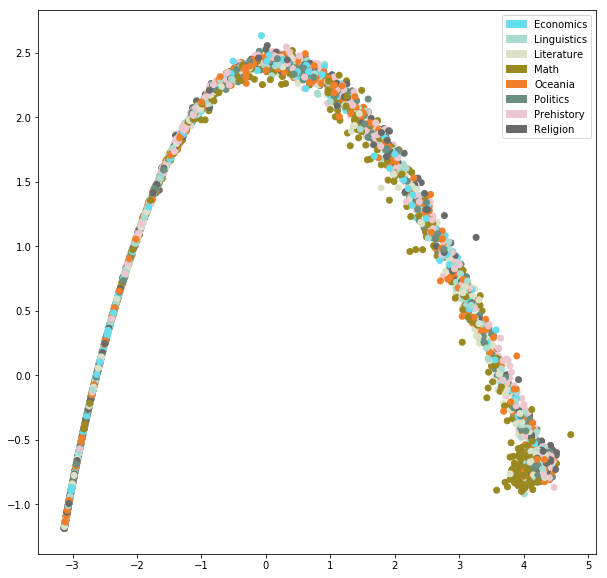

In [76]:
helpers.plot_2D(X_pca, y, le)

### Latent space

Now when we encode our text we get a very different graph. We see a big cluster centered around zero and some clear outliers. Intrestingly enough, the outliers pertain to the “math” class. In the next graph we zoom at the main cluster.

C:\Users\Thibault\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


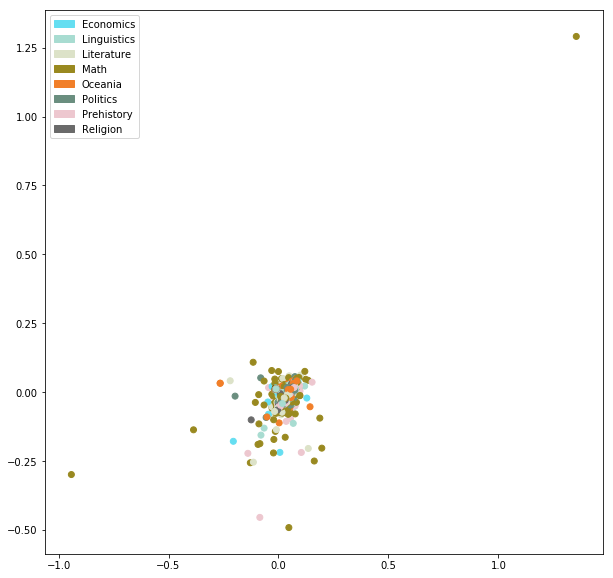

In [82]:
helpers.plot_2D(X_latent, y, le)

Below we see a zoomed version of the previous graph. Here we note two clusters, but both contain what appears to be a random mix of classes. Our encoding seems to have some gaussian properties to it. This is an interesting property, further analysis could reaveal what are the similarities within the two clusters.

C:\Users\Thibault\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


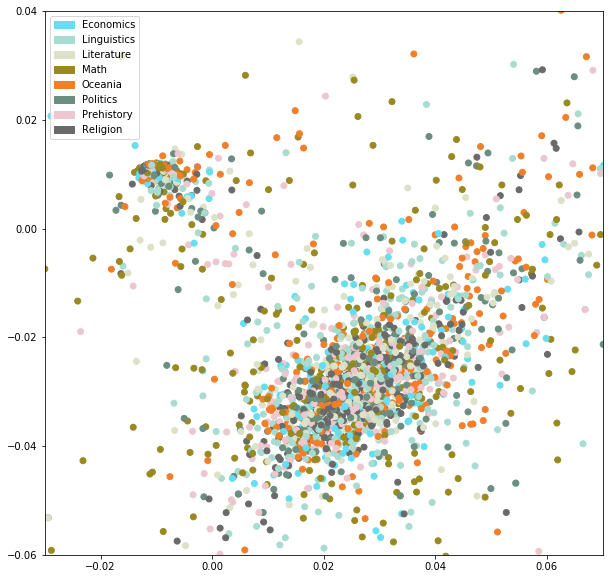

In [40]:
bound = .05
h_shift = .02
v_shift = -.01
helpers.plot_2D(X_latent, y, le, in_range=[[-bound+h_shift,bound+h_shift],[-bound+v_shift,bound+v_shift]])

### What was mistaken for what

Here I was just curious at which classes where confused for which, and I show the top ones.

In [85]:
# Build a dictionary with what class a datapoint was taken to be
cls = {}
for i in range(len(y_latent)):
    cor = y[i]
    oth = y_latent[i]
    is_cor = oth == cor
    if not is_cor:        
        if cor not in cls:
            cls[cor] = [oth]
        else:
            cls[cor].append(oth)
            
a = []
# Count elements in the dictionary for each class
for i, c in cls.items():
    seen = []
    for e in c:
        if e not in seen:
            cnt = c.count(e)
            a.append(f'{cnt:2} times {le.inverse_transform(i)} was taken for {le.inverse_transform(e)}')
            seen.append(e)            
            
sorted(a, reverse=True)[:6]

C:\Users\Thibault\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


['49 times Politics was taken for Economics',
 '48 times Math was taken for Linguistics',
 '40 times Economics was taken for Politics',
 '39 times Literature was taken for Linguistics',
 '38 times Religion was taken for Economics',
 '38 times Oceania was taken for Economics']

I think those confusion make sense at an intuitive level. For example having taken classes on linguistic, I rekon that the vocabulary and formulations can be quite close tho maths.

Below we look at the less current confusions.

In [86]:
sorted(a, reverse=False)[:6]

[' 6 times Math was taken for Religion',
 '13 times Economics was taken for Prehistory',
 '14 times Oceania was taken for Prehistory',
 '16 times Linguistics was taken for Religion',
 '16 times Math was taken for Politics',
 '16 times Math was taken for Prehistory']

We see that every class has been taken for every other class at least six times. Again, it makes sense intuitively that those confusion to be less common.

## Conclusion

We have seen an intersting way to prepare data before classification with a “traditional” classifier. Sadly in this case, it actually made the performance go down. Further investigation is needed to see if the technique could actually work. Two major improvement would be on the dataset (size and quality) and on the autoencoder architecture and parameters.